# Keeneland Venue Analysis and Investment Recommendations

## Introduction
Many people associate horse racing and breeding with the state of Kentucky, and Central Kentucky in particular. Lexington, Kentucky’s official slogan is “Horse Capital of the World,” and it’s impossible to travel backroads in the Bluegrass without driving by miles and miles of pristine horse farms. Although Lexington’s economy has expanded beyond horse racing alone, owing to a large university and decades of relatively rapid development, the city is still highly dependent on the industry and has established an urban/rural boundary to prevent over-development of farmland surrounding the city. 

The center of horse racing in the city is the racetrack Keeneland. Hosting 18 stakes races in its fall 2019 meet with six grade I races and purses topping out at $1 million (Staff, 2019), the track attracts spectators both from the US and globally. The 2019 fall meet had attendance of 262,630 people (Keeneland, 2019). Considering the size of the city is around 330,000 people (US Census Bureau, 2019), the track drives a large part of the local economy during this period. Another meet is scheduled every year in April, with the 2019 spring meet having an attendance of 242,547 people (Keeneland, 2019). The 2020 Breeders’ Cup, one of the premier racing events in the US and in the world, is also on the horizon in November 2020. When Keeneland last hosted this two-day event in 2015 it attracted record attendance with 95,102 attendees (Breeders' Cup, 2015).

Because Keeneland is very important to the city and clearly attracts a great number of visitors, the indirect benefits of racing in the area could influence decision making and new development. As such, the central problem proposed is how to quantify the indirect impact of Keeneland on different neighborhoods and venues. Also, how can this information be leveraged by someone looking to start a business in the area that caters to racetrack attendees? Developing a business themed around horse racing could be a promising venture if placed in the correct location and in the right category. Ideally this business would be relatively easy to start without requiring a great deal of capital investment.

## Literature Review

To analyze the economic impact of Keeneland and racing on the local economy a study was conducted at the University of Kentucky. This study (Bollinger, 2015) measured the economic impact in two areas: racing and sales. In racing, the author relied on survey and sales data to determine that the top categories of spending annually were in retail (over 12M USD), lodging (over 15M USD), food and beverages (over 19M USD), and gasoline (9M USD). The total annual economic impact from racing was estimated at 123M USD directly and 200M USD total. This study is the first to estimate Keeneland’s economic impact.

Although this study measured the economic impact of racing in the area generally, it did not analyze which areas of the city were most impacted and how more specific categories were impacted. This study aims to further evaluate these areas and to recommend specific locations and categories of venues for investment. Based on the prior study, food and beverage may be the best categories for investment, and locations in the city with close proximity to Keeneland may be ideal for development.

## Data

The following data sources were used in determining the ideal location and category placement:

- The Foursquare API (Foursquare, 2020) was used to determine the next venues that users visit after checking       in to a prior venue. This process was needed to evaluate the impact of Keeneland’s visitors on the local         economy. The API was also used to determine what venues are nearby to each chosen location and category. This     was necessary to determine two metrics for determination of ideal locations and venue categories: number of       venues of that category within a 1 km radius and minimum distance to a venue of that category.

- A shapefile for the state of Kentucky (US Census Bureau, 2019) provided by the census bureau was used to         determine the location of each studied point by tract.

- A shapefile for zoning area for the city of Lexington (LFUCG, 2020) was obtained to filter possible locations     to include only those located in business zones

- The Google Maps Geocoding API (Google, 2020) was used to determine the addresses of each chosen location based   on the location’s coordinates.


## Methodology

First, install utm geopandas, and dotenv if necessary, import necessary packages, and set matplotlib inline. Also set chained assignment warning to exception to enable debugging.

In [1]:
#!pip install geopandas
#!pip install utm
#!pip install dotenv

import os
from dotenv import load_dotenv
from zipfile import ZipFile
from io import BytesIO
import geopandas
import json
import requests
import utm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import folium
from folium import plugins
from matplotlib.ticker import FuncFormatter
import re
import seaborn as sns
import pandas as pd
from pandas.io.json import json_normalize

pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline

### Determination of next venues

This class creates the series of dataframes that are compiled using the Foursquare API next venues query. 

The first method, **IterateVenues**, is used to call the API and create a dictionary of the responses. The method also takes a dictionary of venues that have already been assigned next venues. If a new venue is evaluated, the response from Foursquare (Foursquare, 2020) is stored in this dictionary. This saves substantially on compute time. In addition to querying for next venues, the method assignes a weight to each venue returned. The weights assigned are linearly related and are computed using the weights lambda function. The category, venue ID, venue name, and latitude and longitude are stored in a temporary dictionary. The next weight is computed based on the weight of the parent node and is also included for each venue. The results for each next venues call are stored in a list of all next venue results. The already compiled responses are also stored in a dictionary that is returned.

The second method, **FindTract** is used to determine the tract that each venue belongs to. This is needed to filter out venues not in Fayette County and those in rural tracts. In order to determine tract, the method first checks if certain tracts have already been returned. It then orders the geoJSON file to include the tracts that have already been returned first. This substantially reduces the time needed to determine tracts. It then determines the tract ID and the coordinates of the tract. The method uses the geometrical definition of whether a point is inside of a polygon. If a line is drawn to the right from a point and that line either crosses a side of the polygon an odd number of times or the point lies on an edge, that point is inside that polygon. **An illustration of this concept is shown below:** 
![alt text](https://media.geeksforgeeks.org/wp-content/uploads/polygon1.png)
The coordinates given by the geoJSON file are listed in order to draw the polygon. Thus, the sides of the polygon that they create and a slope intercept equation can be derived. First, the method creates a list of all of the min y and max y values as given by latitude, respectively. It searches the geoJSON file for sets of points that have a range of values in which the lattitude of the point lies. After filtering the points based on whether the lattitide lies in between the min and max values, the function determines an equation for the line. It uses the point-slope equation to determine slope and then point intercept to determine intercept. For each side of the tract that has been filtered the longitude value is computed based on the slope intercept equation and the latitude of the point. If the number of these longitude values greater than the slope's longitude is odd or the longitude value is equal to the predicted, the point is determined to be inside the tract. The tract ID of this tract is then returned.

The third method, **TractDF**, compiles a dataframe for each level of analysis. This dataframe includes venue name, ID, latitude, longitude, weight, and tract. For each tract returned in the dataframe, the method checks if this tract has already been selected. If it has, the tract ID is returned from the list. If not, the tract is determined using the **FindTract** function and the tract and tract ID are appended to the tract list. The tract ID is then added to the dataframe.

The fourth method, **LocationDFs**, first takes in the Foursquare credentials, latitude and longitude of the initial location studied, and the category ID of the starting location. The method uses this information to determine the latitude and longitude listed by Foursquare for the venue, category name, and venue name. This information is added as a tuple in a list. This list of one tuple is passed to the **IterateVenues** function, which is iterated a certain number of times defined by the class. The results from each layer are stored in a list and after all layers are iterated through the list of dataframes is returned.

In [2]:
class LocationDispersion:
    """
    Create dataframes of next venue results at various levels. Each level 
    is dependent on the Foursquare next venue results from the previous level.
    Starts with venue of certain latitude, longitude, and category id. 
    
    Foursquare API credentials are needed to create the dataframes. For the 
    number of calls, the 'Personal' tier may be needed. None of the calls are 
    rated as 'Premium'.
    
    Available category ids are available at:
    https://developer.foursquare.com/docs/build-with-foursquare/categories/.
    
    Note the the class structure is based on the KY census tract geojson available 
    from KY Geonet. This geojson is available at:
    https://opendata.arcgis.com/datasets/d7e0ae24e6ea478eb405a2d292ce19f6_0.geojson.
    Other geojson files may not be compatible. 
    
    The parameter 'n' is the number of desired levels in the analysis.
    
    Note that the LocationDFs method may take a while to run as it iterates through
    the geojson for each venue.
    """
    weights = lambda self, x: [i * 1/((x+1)*(x//2)+(x%2)*((x+1)/2)) 
                               for i in range(x, 0, -1)]
    
    def __init__(self, latitude, longitude, category_id, census_json, n, 
                 CLIENT_ID, CLIENT_SECRET, VERSION):
        self.latitude = latitude
        self.longitude = longitude
        self.category_id = category_id
        self.census_json = census_json
        self.n = n
        self.CLIENT_ID = CLIENT_ID
        self.CLIENT_SECRET = CLIENT_SECRET
        self.VERSION = VERSION
        
    def IterateVenues(self, response, all_responses):
        """
        Iterates through level of venues to create next level. 
        Outputs list with relevent information on next venues.
        """
        next_responses = list()
        for venue in response:
            venue_id = venue[1]
            if venue_id in all_responses.keys():
                next_results = all_responses[venue_id]
            else:
                next_url = 'https://api.foursquare.com/v2/venues/{}/nextvenues?client_id={}&client_secret={}&v={}'\
                    .format(venue_id, self.CLIENT_ID, self.CLIENT_SECRET, self.VERSION)
                next_results = requests.get(next_url).json()
                all_responses[venue_id] = next_results
            prev_weight = venue[5]
            next_venues = list()
            if not next_results["response"]:
                continue
            count = next_results["response"]["nextVenues"]["count"]
            next_weights = [prev_weight * weight for weight in self.weights(count)]
            results = next_results["response"]["nextVenues"]["items"]
            for i in range(len(results)):
                next_id = results[i]["id"]
                next_name = results[i]["name"]
                category = results[i]["categories"][0]["name"]
                lat = results[i]["location"]["lat"]
                long = results[i]["location"]["lng"]
                visit_weight = next_weights[i]
                next_venues.append((next_name, next_id, category, lat, long, 
                                    visit_weight))
            next_responses.extend(next_venues)
        return next_responses, all_responses
    
    def FindTract(self, lat, long, prev=None):
        """
        Iterates through geojson file to extract correct census tract using lat and long.
        Utilizes basic geometrical definition of a polygon.
        """
        tracts = sorted(self.census_json["features"], key=lambda x: x["properties"]
                        ["GEOID"])
        if prev and any(x for x in prev):
            county_ids = set([x[2:5] for x in prev if x])
            tracts1 = [tract for tract in tracts if tract["properties"]["COUNTYFP"]
                       in county_ids]
            tracts2 = [tract for tract in tracts if tract["properties"]["COUNTYFP"]
                       not in county_ids]
            tracts = tracts1 + tracts2
        for tract in tracts:
            tract_id = tract["properties"]["GEOID"]
            coords = tract["geometry"]["coordinates"][0]
            long_preds = list()
            if len(coords) < 2:
                continue
            ymax = [max([coords[i][1], coords[i-1][1]]) for i in range(1, len(coords))]
            ymin = [min([coords[i][1], coords[i-1][1]]) for i in range(1, len(coords))]    
            new_coords = list()
            for i in range(1, len(coords)):
                if (lat > ymin[i-1] and lat < ymax[i-1]) \
                    or (i < len(ymin)-1 and lat == ymin[i - 1] and ymax[i - 1] > lat and ymin[i] < lat):
                        new_coords.append([coords[i-1],coords[i]])
            if new_coords:
                for i in range(len(new_coords)):
                    x_diff = new_coords[i][1][0] - new_coords[i][0][0]
                    y_diff = new_coords[i][1][1] - new_coords[i][0][1]
                    m = y_diff / x_diff
                    b = new_coords[i][1][1] - m * new_coords[i][1][0]
                    if m == 0:
                        long_pred = -b
                    else:
                        long_pred = (lat-b)/m
                    long_preds.append(long_pred)
            if long_preds and (sum(pred > long for pred in long_preds) % 2 == 1\
                or any(long == pred for pred in long_preds)):
                return tract_id
        print("Venue outside of Kentucky")
        return None
    
    def TractDF(self, layer, prev_tracts=None):
        """
        Creates dataframe for each layer. Uses FindTract to determine tract number 
        and GetLikes to determine like count.
        """
        venues_df = pd.DataFrame()
        venues_df["Venue"] = [v[0] for v in layer]
        venues_df["Id"] = [v[1] for v in layer]
        venues_df["Category"] = [v[2] for v in layer]
        venues_df["Latitude"] = [v[3] for v in layer]
        venues_df["Longitude"] = [v[4] for v in layer]
        venues_df["VisitWeight"] = [v[5] for v in layer]
        tracts = list()
        if not prev_tracts:
            prev_tracts = dict()
        for i in range(venues_df.shape[0]):
            ID = venues_df.iloc[i,1]
            if ID in prev_tracts.keys():
                tracts.append(prev_tracts[ID])
            else:
                lat = venues_df.iloc[i,3]
                long = venues_df.iloc[i,4]
                tract = self.FindTract(lat, long, tracts)
                tracts.append(tract)
                prev_tracts[ID] = tract
        venues_df["Tract"] = tracts
        print("Layer finished.")
        return prev_tracts, venues_df
    
    def LocationDFs(self):
        """
        Creates list of DFs for each desired level of analysis for given location. 
        Uses all prior functions to generate.
        """    
        venues_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}'\
            .format(self.CLIENT_ID, self.CLIENT_SECRET, self.VERSION, self.latitude, 
                self.longitude, self.category_id)
        venue_results = requests.get(venues_url).json()
        venue_response = venue_results["response"]["venues"][0]
        venue_id = venue_response["id"]
        venue_name = venue_response["name"]
        venue_cat = venue_response["categories"][0]["name"]
        venue_lat = venue_response["location"]["lat"]
        venue_long = venue_response["location"]["lng"]
        venue = [(venue_name, venue_id, venue_cat, venue_lat, venue_long, 1)]
        layers = [venue]
        all_responses = dict()
        for i in range(self.n):
            next_responses, all_responses = self.IterateVenues(layers[i], all_responses)
            layers.append(next_responses)
        dfs = list()
        prev_tracts = None
        for layer in layers:
            prev_tracts, df = self.TractDF(layer, prev_tracts)
            dfs.append(df)
        return dfs

The census data for Kentucky is available from the census bureau as a shapefile (US Census Bureau, 2019). This shapefile is stored in a zip file. **Requests** is used along with the census URL to extract the data from the site for the zip file. This zip file is written to a zip file stored locally, which is then extracted using the **zipfile** package. The **geopandas** package is then used to read the contents of the shapefile and convert it into geoJSON format, which is then loaded and stored as the variable census_json.

In [3]:
census_url = "https://www2.census.gov/geo/tiger/TIGER2017/BG/tl_2017_21_bg.zip"

request = requests.get(census_url)
open('census.zip', 'wb').write(request.content)
with ZipFile("census.zip", 'r') as zip_ref:
    zip_ref.extractall()

myshpfile = geopandas.read_file('tl_2017_21_bg.shp')
myshpfile.to_file('census.json', driver='GeoJSON')

with open('census.json') as f:
  census_json = json.load(f)

The Foursquare credentials along with the category ID for racetracks is supplied.

In [4]:
load_dotenv()

category_id = '4bf58dd8d48988d1f4931735'
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')
VERSION = '20200529'

The latitude and longitude of Keeneland are supplied and the **LocationDFs** method of the **LocationDispersion** class is used to extract dataframes for six levels of analysis. Note that this process may take several seconds to complete.

In [5]:
keene_lat = 38.0461
keene_long = -84.6080
loc = LocationDispersion(keene_lat, keene_long, category_id, 
    census_json, 6, CLIENT_ID, CLIENT_SECRET, VERSION)
keene_dfs = loc.LocationDFs()

Layer finished.
Layer finished.
Layer finished.
Layer finished.
Layer finished.
Layer finished.
Layer finished.


The dataframes from each level of analysis are concatenated to form a full dataframe. The Fall 2019 meet attendance is then used to determine the total number of visits by venue based on visit weight.

In [6]:
keene_df = pd.DataFrame()
for layer in keene_dfs[1:]:
    keene_df = pd.concat([keene_df, layer], axis=0)
keene_attendance = 262630 # Source: https://keeneland.com/media/news/strong-attendance-and-community-events-highlight-keeneland-fall-meet
keene_df["Visits"] = keene_df["VisitWeight"] * keene_attendance

The dataframe is grouped by venue and the number of visits and number of mentions for each venue were determined.

In [7]:
agg_visit = {row:"first" for row in ["Id", "Category", "Latitude", "Longitude", "Tract"]}
agg_visit["Visits"] = "sum"
agg_visit["VisitWeight"] = "count"

visit_df = keene_df.groupby("Venue").agg(agg_visit)
visit_df.rename(columns={"VisitWeight":"Mentions"}, inplace=True)

### Creation of points of interest to study

The county code for Fayette County is used to filter out all tracts from other counties, as they are not within the scope of this analysis.

In [8]:
fayette_code = '067'
lex_visits = visit_df[visit_df["Tract"].apply(lambda x: str(x)[2:5]) == fayette_code].copy()

The generalized tract numbers are extracted and the latitude and longitude are converted to x and y coordinates using the **utm** package.

In [9]:
lex_visits.loc[:,"Block"] = lex_visits.loc[:,"Tract"]
lex_visits.iloc[:,4] = lex_visits.iloc[:,4].apply(lambda x: str(x)[:-1])
lex_visits.reset_index(inplace=True)
lex_visits.loc[:,"X"], lex_visits.loc[:,"Y"], lex_visits.loc[:,"zone_num"], lex_visits.loc[:,"zone_let"] \
    = zip(*lex_visits.copy().apply(lambda x: utm.from_latlon(x[3], x[4]), axis=1))

The rural tracts in Fayette County are excluded from this analysis as only venues in the city with other nearby venues are considered.

In [10]:
rural_tracts = ['21067003701', '21067003802','21067004207']
lex_urban = lex_visits[~lex_visits["Tract"].isin(rural_tracts)]
lex_urban = lex_urban.reset_index().drop("index", axis=1)

The census json file is filtered to include only tracts within Fayette County.

In [11]:
lex_json = census_json.copy()
lex_json["features"] = [tract for tract in census_json["features"] if tract["properties"]["COUNTYFP"] == fayette_code]

The x and y coordinates for each venue are extracted and scaled. These scaled coordinates are then passed into K Means clustering algorithms with number of cluseters ranging from 1 to 14. The sum of squared errors is appended to a list for each number of clusters used.

In [12]:
lex_urban_xy = lex_urban[["X", "Y"]].values
scaler1 = StandardScaler()
lex_xy_scaled = scaler1.fit_transform(lex_urban_xy)
sum_squared = list()
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(lex_xy_scaled)
    sum_squared.append(kmeans.inertia_)

An elbow chart is created using the sum of squared distances for each value of number of clusters. Based on this chart, the elbow appears to be at either 3 or 4.

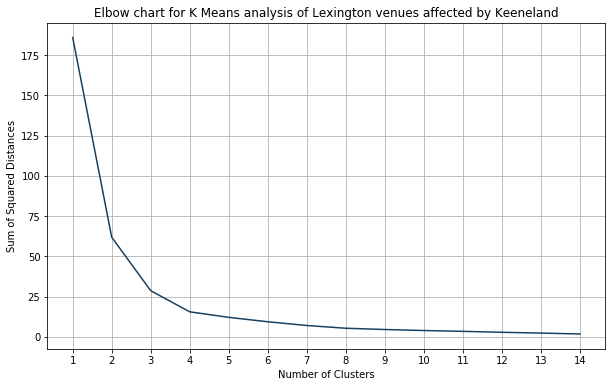

In [55]:
plt.figure(figsize=(10,6))
plt.plot(range(1,15), sum_squared)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow chart for K Means analysis of Lexington venues affected by Keeneland")
plt.xticks(ticks=range(1,15))
plt.grid(b=True)
plt.savefig("kmeans_all_venues.png")
plt.show()

A final K Means algorithm is fitted using 4 clusters determined using the elbow method. The centers of the clusters are then inverse transformed to determine their centers in x and y coordinates.

In [14]:
k = 4 # Elbow on elbow chart.
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(lex_xy_scaled)
centers = scaler1.inverse_transform(kmeans.cluster_centers_)

The zone number and letter for the region are extracted from the dataframe of urban venues, and these are used to transform the centers in x and y coordinates back to latitude and longitude so that the centers can be plotted.

In [15]:
zone_num = lex_urban.loc[0, "zone_num"]
zone_let = lex_urban.loc[0, "zone_let"]
centers_ll = list()
for ll in centers:
    centers_ll.append(utm.to_latlon(ll[0], ll[1], zone_num, zone_let))

The cluster centers are plotted using **folium** and the latitude and longitude of downtown Lexington. The clusters are plotted as circles with a radius of 1 km. These centers are plotted on top of a heatmap showing the density of venues visited by Keeneland goers.

In [45]:
lex_urban_arr = lex_urban[["Latitude", "Longitude"]].values

lex_lat = 38.0406
lex_long = -84.5037

lex_map = folium.Map(location=[lex_lat, lex_long], zoom_start=12)
for center in centers_ll:
    folium.Circle([center[0], center[1]], radius=1000, color='green', fill=True, fill_opacity=0.25).add_to(lex_map)
lex_map.add_child(plugins.HeatMap(lex_urban_arr, radius=15))

lex_map.save('lex_map.html')

lex_map

Based on the x and y location of each cluster center, a series of points was generated at constant intervals away from those centers. These points were generated in an 11 x 11 grid spanning 1500 meters in every direction away from the center. The locations were then appended to a list with the x and y coordinates converted to latitude and longitude using the **utm** package. A dataframe was created using these coordinates.

In [17]:
chosen_loc_radius = 1500
diff = 300

locations = list()
for center in centers:
    new = [[center[0] + x, center[1] + y] 
           for x in range(-chosen_loc_radius, chosen_loc_radius+1, diff) 
           for y in range(-chosen_loc_radius, chosen_loc_radius+1, diff)]
    for n in new:
        locations.append(utm.to_latlon(n[0], n[1], zone_num, zone_let))
loc_df = pd.DataFrame(locations, columns=["Latitude", "Longitude"])

Next, the zones for each point were determined in order to filter out points not zoned for business. This was completed using a shapefile of zoning in Lexington (LFUCG, 2020) obtained from the Lexington city datasets. The process of extracting the shapefile and converting this file to a usable GeoJSON file is the same as used to determine census tracts.

In [18]:
lex_zoning_zip_url = "https://data.lexingtonky.gov/dataset/d99942a6-2828-496b-b675-82d3cb94e54d/resource/434a9cd5-f7b4-4af4-94a0-038d020081f2/download/zoning.zip"

request = requests.get(lex_zoning_zip_url)
open('zoning.zip', 'wb').write(request.content)

with ZipFile("zoning.zip", 'r') as zip_ref:
    zip_ref.extractall()

myshpfile = geopandas.read_file('Zoning.shp')
myshpfile.to_file('zoning.json', driver='GeoJSON')

with open('zoning.json') as f:
  zoning = json.load(f)

This function is used to determine to which zone in Lexington a specific latitude and longitude coordinate belongs. The process of extracting coordinates is the same as that used to determine tract number. The definition of a point inside a polygon is used, in addition to coordinates supplied by the geojson, to determine to which zone each point belongs. The zone is returned. If the point is not inside the geoJSON file, None is returned.

In [19]:
def FindZone(lat, long, geojson):
        """
        Iterates through geojson file to extract correct census tract using lat and long.
        Utilizes basic geometrical definition of a polygon.
        """
        for zone in geojson["features"]:
            zone_id = zone["properties"]["ZONING"]
            coords = zone["geometry"]["coordinates"][0]
            if len(coords) < 3:
                coords = coords[0]
            long_preds = list()
            ymax = [max([coords[i][1], coords[i-1][1]]) for i in range(1, len(coords))]
            ymin = [min([coords[i][1], coords[i-1][1]]) for i in range(1, len(coords))]
            new_coords = list()
            for i in range(1, len(coords)):
                if lat > ymin[i-1] and lat < ymax[i-1]:
                        new_coords.append([coords[i-1],coords[i]])
            if new_coords:
                for i in range(len(new_coords)):
                    x_diff = new_coords[i][1][0] - new_coords[i][0][0]
                    y_diff = new_coords[i][1][1] - new_coords[i][0][1]
                    m = y_diff / x_diff
                    b = new_coords[i][1][1] - m * new_coords[i][1][0]
                    if m == 0:
                        long_pred = -b
                    else:
                        long_pred = (lat-b)/m
                    long_preds.append(long_pred)
            if long_preds and (sum(pred > long for pred in long_preds) % 2 == 1\
                or any(long == pred for pred in long_preds)):
                return zone_id
        return None

Now the **FindZone** function is used to filter out all points not in a business zone, excluding zone "B-4", which is a wholesale business zone and is outside of the scope of this analysis. The zone is then dropped after being used to filter the points.

In [20]:
loc_df["Zone"] = loc_df.apply(lambda x: FindZone(x[0], x[1], zoning), axis=1)
bus_df = loc_df[loc_df["Zone"].apply(lambda x: False if not x else (x.split("-")[0] == "B")
                                     &(x.split("-")[1] != "4"))]
bus_df = bus_df.reset_index().drop(["index", "Zone"], axis=1)

This **folium** map shows clusters of markers for the chosen locations. These markers are again overlayed on the heatmap of venues with Keeneland visits to give an understanding of where these locations are relative to visited venues. Most points are clustered in Downtown, along Harrodsburg Road, shown as "US 68", and along Nicholasville Road, shown as "US 27".

In [21]:
lex_lat = 38.0406
lex_long = -84.5037

bus_map = folium.Map(location=[lex_lat, lex_long], zoom_start=12)
bus_cats = plugins.MarkerCluster().add_to(bus_map)


for lat, lng in zip(bus_df.Latitude,bus_df.Longitude):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=None,
    ).add_to(bus_cats) 

bus_map.add_child(plugins.HeatMap(lex_urban_arr, radius=15))

bus_map.save("bus_map.html")

bus_map

### Category choice by point

This function converts latitude and longitude to x and y coordinates using the **utm** package. It then computes the distance between two points in meters. This will be used to determine how close visited venues are to each point.

In [22]:
def LatLonDist(latlon1, latlon2):
    """
    Determines distance in m between two points based on latitude and longitude.
    """
    x1, y1, zone1, d1 = utm.from_latlon(latlon1[0], latlon1[1])
    x2, y2, zone2, d2 = utm.from_latlon(latlon2[0], latlon2[1])
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

The **LatLongDist** function is used to determine the distance of each visited venue to each point studied. This is stored in a temporary dataframe and then concatenated.

In [23]:
loc_all_df = pd.DataFrame()
for i in range(bus_df.shape[0]):
    dist_df = lex_urban.iloc[:,:7]
    dist_df["Distance"] = dist_df.apply(lambda x: LatLonDist([x[3], x[4]], bus_df.iloc[i,:]), axis=1)
    dist_df.drop(["Latitude", "Longitude"], axis=1, inplace=True)
    dist_df["Latitude"] = bus_df.iloc[i,0]
    dist_df["Longitude"] = bus_df.iloc[i,1]
    loc_all_df = pd.concat([loc_all_df, dist_df], axis=0)

Next the top categories were determined based on number of total visits. The top 5 of these categories were compiled excluding grocery stores and supermarkets that were deemed too large of investments. The indices for the top categories were derived to enable highlighting the chosen categories while plotting.

In [24]:
cat_visits = lex_urban.groupby("Category").sum()[["Visits"]].sort_values(by="Visits", ascending=False)
cat_limit = 5
exc_cat = ["Grocery Store", "Supermarket"]
cat_top = cat_visits[~cat_visits.index.isin(exc_cat)][:cat_limit]
cat_visits.reset_index(inplace=True)
cat_top_i = [i for i in range(cat_visits.shape[0]) if cat_visits.iloc[i,0] in cat_top.index.to_list()]

The visits in each of the chosen top categories are shown below.

In [25]:
cat_top

,Visits
Category,
Steakhouse,45749.549408
Ice Cream Shop,19424.907373
American Restaurant,12108.653781
Liquor Store,11518.817783
German Restaurant,4147.527894


These are the top 15 categories by visits. The chosen categories are highliqhted in red. They will be used to determine which categories to focus on for each point.

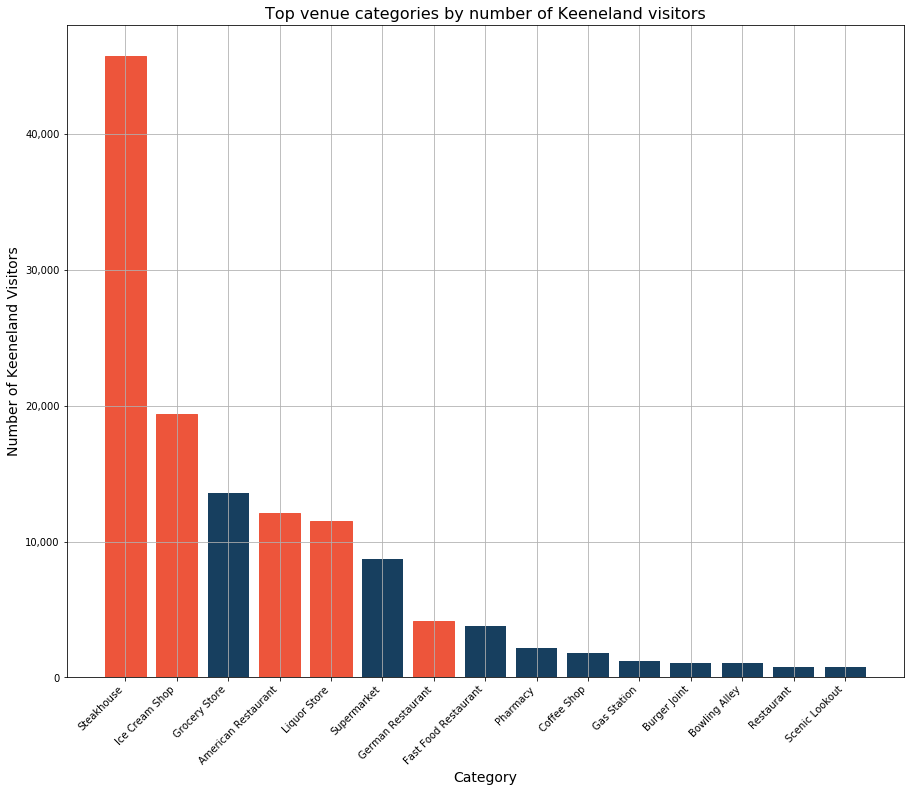

In [46]:
plt.figure(figsize=(15,12))
ax = plt.subplot(111)
bar = ax.bar("Category", "Visits", data=cat_visits.iloc[:15,:])
for i in cat_top_i:
    bar[i].set_color("#ED553B")
ax.set_xticklabels(labels=cat_visits.iloc[:15,:]["Category"],rotation=45, ha="right")
ax.set_xlabel("Category", fontsize=14)
ax.set_ylabel("Number of Keeneland Visitors", fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(b=True)
ax.set_title("Top venue categories by number of Keeneland visitors", fontsize=16)

plt.savefig("top_venues.png")
plt.show()

Next, the visited venues are filtered by distance from the studied point. This distance was chosen as 1 km. The dataframe containing nearby venues was then grouped by location and category of venue to determine which categories were at each location. The grouped dataframe was then used to extract the unique coordinates and the categories located near each of these coordinates.

In [27]:
loc_radius = 1000
loc_radius_df = loc_all_df[loc_all_df["Distance"] < loc_radius]
loc_grouped = loc_radius_df.groupby(["Latitude", "Longitude", "Category"]).count()
cat_lat = loc_grouped.index.get_level_values(0).unique().to_list()
cat_long = loc_grouped.index.get_level_values(1).unique().to_list()
groups = [loc_grouped.loc[cat_lat[i],:].index.get_level_values(1).to_list() for i in range(len(cat_lat))]

The top categories not nearby each point were determined and these were saved back into the list of categories by point.

In [28]:
for i in range(len(groups)):
    cats = cat_top.index.to_list()
    for cat in groups[i]:
        if cat in cats:
            cats.remove(cat)
    groups[i] = cats    

### Nearby venues and metrics derivation

This function is then used to convert the category names to ID numbers to be interpreted by the Foursquare API.

In [29]:
def GetCatID(cat):
    """
    Determines the category ID by category using Foursquare API data.
    """
    venues_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'\
                .format(CLIENT_ID, CLIENT_SECRET, VERSION)
    venue_results = requests.get(venues_url).json()
    venue_text = json.dumps(venue_results)
    cat_id = re.findall('(?<=id\"\:\s\")\w+(?=[^\}]+\s\"%s\")' % cat, venue_text)[0]
    return cat_id

The IDs for catgories that do not have visited venues located nearby to each point, the latitude and longitude of each point, a 1 km radius, and a limit of 20 returned venues are then used to query the Foursquare API. For each category by point, the loop first checks if there are any categories not included at that venue. If not, it skips that location, appends None to the list of returned venues, and continues. 

It then determines the coordinated and the category ID, which it uses to query the API. If there are no nearby venues returned, the loop creates temporary dictionary with null values for the ID of the venue, name, and distance. It then appends this dictionary to a list of venues at each point. If the API does return nearby venues in that category, these reusults are looped to obtain a dictionary of ID, name, and distance fro the point for each venue. 

These dictionaries are then appended to the list of venues for each point. This temporary list by point is then appended to the full list of returned venues by location. Note that this process may take several seconds.

In [30]:
limit = 20
all_cats = list()
for i in range(len(groups)):
    if not groups[i]:
        all_cats.append(None)
        continue
    group = groups[i]
    lat = cat_lat[i]
    long = cat_long[i]
    cats = dict()
    for cat in group:
        cat_id = GetCatID(cat)
        venue_url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}&categoryId={}"\
            .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, limit, loc_radius, cat_id)
        venue_results = requests.get(venue_url).json()
        venues = list()
        if not venue_results["response"]["venues"]:
            venue_dict = dict()
            venue_dict["ID"] = np.nan
            venue_dict["name"] = np.nan
            venue_dict["distance"] = np.nan
            venues.append(venue_dict)
        else:
            for venue in venue_results["response"]["venues"]:
                venue_dict = dict()
                venue_dict["ID"] = venue["id"]
                venue_dict["name"] = venue["name"]
                venue_dict["distance"] = venue["location"]["distance"]
                venues.append(venue_dict)
        cats[cat] = venues
    all_cats.append(cats)

After a list of returned nearby venues by category is created, a dataframe is created for each point including its returned venues. This dataframe is then concatenated to form a complete dataframe of nearby venues in each category.

In [31]:
all_loc_cat = pd.DataFrame()
for i in range(len(all_cats)):
    if not all_cats[i]:
        continue
    all_cat_df = pd.DataFrame()
    for k,v in all_cats[i].items():
        cat_df = pd.DataFrame(all_cats[i][k])
        cat_df["category"] = k
        all_cat_df = pd.concat([all_cat_df, cat_df], axis=0)
    all_cat_df["Latitude"] = cat_lat[i]
    all_cat_df["Longitude"] = cat_long[i]
    all_loc_cat = pd.concat([all_loc_cat, all_cat_df], axis=0)

The dataframe containing nearby venues is then grouped by location and category to determine minimum distance to a venue of that cateogory and the number of venues nearby in each category. If there are no nearby venues in that category, the grouped dataframe will include zero for number of venues nearby and null values for minimum distance.

In [32]:
loc_cat_agg = {"distance": "min", "ID": "count"}
possible_df = all_loc_cat.groupby(["Latitude", "Longitude", "category"]).agg(loc_cat_agg)
possible_df.reset_index(inplace=True)
possible_df.rename(columns={"distance": "min_dist", "ID": "num_nearby"}, inplace=True)

Below is the head of the dataframe containing category by coordinated with minimum distance to a venue in that category amd number of venues roughly within 1 km. The Foursquare call returns some venues that are outside of the radius given, so not all categories will have venues with minimum distance less than 1 km.

In [33]:
possible_df.head()

,Latitude,Longitude,category,min_dist,num_nearby
0,37.978356,-84.532091,American Restaurant,212.0,5
1,37.978356,-84.532091,German Restaurant,NaN,0
2,37.978356,-84.532091,Ice Cream Shop,456.0,3
3,37.978356,-84.532091,Liquor Store,1236.0,1
4,37.978356,-84.532091,Steakhouse,367.0,1


A metric for Keeneland visitor proximity was also derived. The first step in determing this metric for each point was grouping the dataframe including all visits within a 1 km radius by the location of each point. This was used to determine the number of visits within 1 km of each point.

In [34]:
loc_visits = loc_radius_df.groupby(["Latitude", "Longitude"]).sum()[["Visits"]]
loc_visits.reset_index(inplace=True)

As the number of visits is an approximation, a function was created that takes in any number and rounds it to a certain number of significant figures.

In [35]:
def SigFigs(num, sig_figs):
    """
    Takes number and rounds to certain number of significant figures.
    """
    if num >= 1:
        i = 0
        while num // 10**i > 10:
            i += 1
    if num < 1:
        i = -1
        while num // 10**i == 0:
            i-= 1
    power_num = num * 10**-i
    rounded = round(power_num, sig_figs-1)
    return rounded * 10**i 

First, the number of signifant figures is set at 2 due to the high level of uncertainty. The minimum distance figure for locations without a nearby venue was set to 2 km, as the points are outside of a 1 km range but still likely not too far away from a venue of that category. 

The dataframe with visits within a 1 km radius by location was then merged with the dataframe containing data on proximity to nearby venues. Next the dataframe containing number of visits by category was merged with this dataframe. 

The number of visits within 1 km and the number of visits by category were then rounded to 2 significant figures using the **SigFigs** function. Finally the "Category" column was redundant and thus dropped.

Thus, four metrics were derived for consideration in choosing a final venue: minimum distance to a venue in that category, number of venues in that category roughly within 1 km, number of visits within 1 km of the venue, and number of visits in that category.

In [36]:
sig_figs = 2

possible_df["min_dist"].fillna(2000,inplace=True)
possible_df = pd.merge(possible_df, loc_visits, on=["Latitude", "Longitude"])
possible_df = pd.merge(possible_df, cat_visits, left_on="category", right_on="Category")
possible_df.rename(columns={"Visits_x": "RadiusVisits", "Visits_y": "CatVisits"}, inplace=True)
possible_df["RadiusVisits"] = possible_df["RadiusVisits"].apply(lambda x: SigFigs(x, sig_figs))
possible_df["CatVisits"] = possible_df["CatVisits"].apply(lambda x: SigFigs(x, sig_figs))
possible_df.drop("Category", axis=1, inplace=True)

In order to get a better understanding of the distribution of the four chosen metrics across all studied points, histogram subplots were generated for each metric. Each histogram was grouped using 30 bins, except for in category visits, which was grouped using 20 bins. 

As shown in the figure below, the minimum distance is skewed left with many of the points with nearby venues having a relatively short distance to those venues. However, there are a large number of venues with a 2 km minimum distance, which, as previously described, indicates that there were no nearby venues in that category within 1 km. The histogram for number of venues nearby indicates that again the distribution is skewed left, with most location category pairs having under 4 venues nearby. There is a sizable number of pairs with 0 nearby venues.

Number of visits in a 1 km radius is heavily skewed left, with the vast majority of points having relatively very few visits. However, there is one area with vastly more visits, at around 97,000. This indicates that the number of visitors from Keeneland is highly concentrated in certain areas but relatively low at most locations. The number of visits in each category is again slightly left skewed, but relatively uniform.

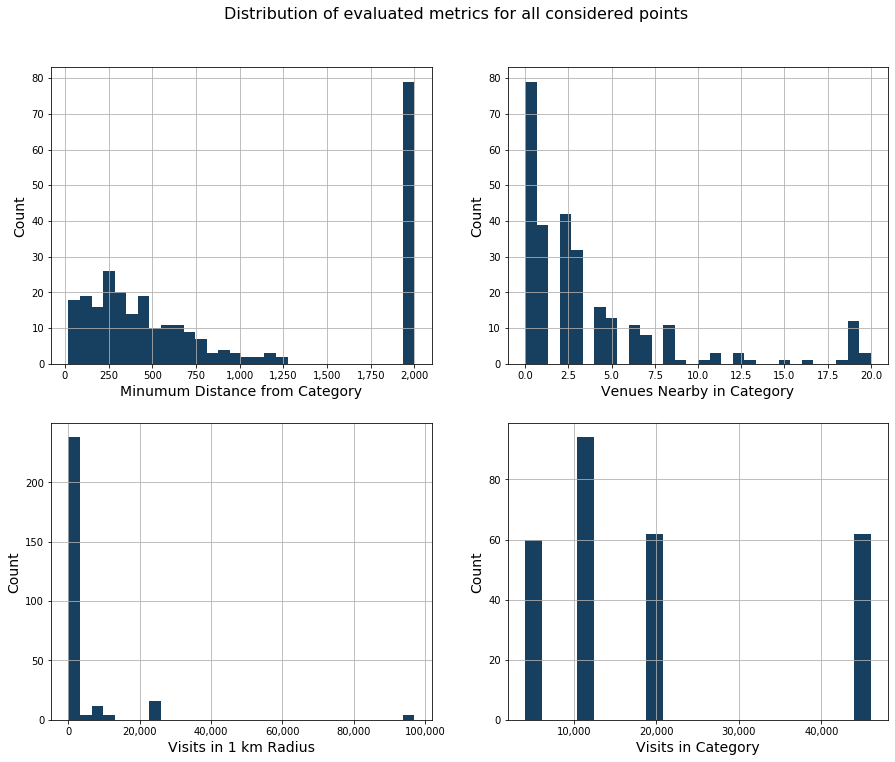

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(15,12))
ax[0,0].hist("min_dist", bins=30, data=possible_df)
ax[0,0].xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0,0].set_xlabel("Minumum Distance from Category", fontsize=14)
ax[0,1].hist("num_nearby", bins=30, data=possible_df)
ax[0,1].set_xlabel("Venues Nearby in Category", fontsize=14)
ax[1,0].hist("RadiusVisits", bins=30, data=possible_df)
ax[1,0].set_xlabel("Visits in 1 km Radius", fontsize=14)
ax[1,1].hist("CatVisits", bins=20, data=possible_df)
ax[1,1].set_xlabel("Visits in Category", fontsize=14)
for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel("Count", fontsize=14)
        ax[i,j].grid(b=True)
        if (i,j) != (0,1):
            ax[i,j].xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))           
fig.suptitle("Distribution of evaluated metrics for all considered points", y=0.95, fontsize=16)
plt.savefig("metric_dist.png")
plt.show()

A series of subplots was then used to further examine the distributions by category, shown in the figure below. These distributions are shown as boxplots for minimum distance from category, venues nearby, and visits in a 1 km radius. The outliers are excluded for this visualization. Because there are only 5 categories chosen, the visits by category is discrete and is shown again as a bar plot. American restaurants have the narrowest distribution for minimum distance with the lowest values for quartiles and median. This category also has the highest values for quartiles and median and the widest range for nearby venues. This indicates that American restaurants are widespread and numerous. 

Ice cream shops have the greatest range for minimum distance and the highest median and third quartile for number of venues nearby. These venues also appear to be nearby to a large number of pairs, while their distance from the pairs varies widely. Steakhouses appear to be the least common in nearby venues, with the by far the lowest third quartile. While the medians and ranges differ slightly, the number of visits within a 1 km radius seem to be fairly similarly distributed across all five categories. No single category is superior across all four metrics based on distribution.

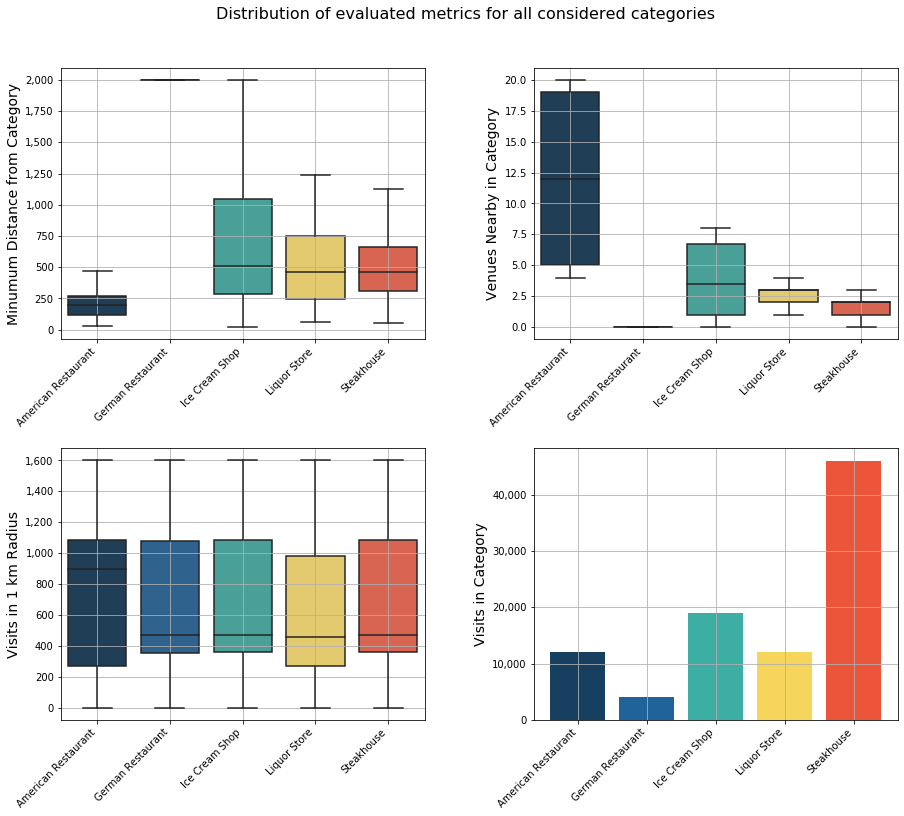

In [61]:
colors = ["#173F5F", "#20639B", "#3CAEA3", "#F6D55C", "#ED553B"]
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(2, 2, figsize=(15,12))
fig.subplots_adjust(hspace=.4,wspace=.3)
sns.boxplot(x="category", y="min_dist", data=possible_df, showfliers=False, ax=ax[0,0])
ax[0,0].set_ylabel("Minumum Distance from Category", fontsize=14)
sns.boxplot(x="category", y="num_nearby", data=possible_df, showfliers=False, ax=ax[0,1])
ax[0,1].set_ylabel("Venues Nearby in Category", fontsize=14)
sns.boxplot(x="category", y="RadiusVisits", data=possible_df, showfliers=False, ax=ax[1,0])
ax[1,0].set_ylabel("Visits in 1 km Radius", fontsize=14)
ax[1,1].bar(x="category", height="CatVisits", 
            data=possible_df.groupby("category").agg("first").reset_index(), color=colors)
ax[1,1].set_ylabel("Visits in Category", fontsize=14)
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(None)
        ax[i,j].set_xticklabels(possible_df["category"].unique(), rotation=45, ha="right")
        ax[i,j].grid(b=True)
        if (i,j) != (0,1):
            ax[i,j].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.suptitle("Distribution of evaluated metrics for all considered categories", y=0.95, fontsize=16)
plt.savefig("cat_dist.png")
plt.show()

### Final location-categories choice

A function was created to determine which category-point pairs were most ideal. This is accomplished by filtering out points deemed inherently inferior. To be inherently inferior, a pair has to be inferior to at least one other point in one metric and either equal to or inferior to that point in all other metrics. This function takes a dataframe, an index of the point considered, and a dictionary of the column index of considered metrics and whether the superior value of this metric is "high" or "low". It then returns whether the point is ideal.

In [39]:
def FindIdeal(df, start, index_dir):
    """
    Determines whether a point is ideal based on criteria given 
    by their column index and direction (index_dir). Takes index_dir
    in form {index:dir} where dir is 'low' indicating low values are ideal
    or 'high' indicating high values are ideal. Also takes df and start row
    index that is studied.
    """
    all_s = list()
    for i in range(df.shape[0]):
        s = 0
        for k,v in index_dir.items():
            best1 = df.iloc[start,k]
            best2 = df.iloc[i, k]
            if best1 == best2:
                continue
            if v == "high":
                if best1 > best2:
                    s = 0
                    break
                else:
                    s -= 1
            elif v == "low":
                if best1 < best2:
                    s = 0
                    break
                else:
                    s -= 1
        all_s.append(s)
    return sum(all_s) == 0

The address of each ideal pair was also required in order to better present possible locations to developers. These addresses were determined using the Google Maps Geocoding API (Google, 2020). This API has a query that determines the address of a point based on its coordinates. A function was created to streamline this process.

In [40]:
GOOGLE_API_KEY = os.environ.get('GOOGLE_KEY')

def FindAddress(lat, long):
    """
    Relies on Google Maps Geocoding API to match coordinates of a point with the point's address.
    """
    geo_url = "https://maps.googleapis.com/maps/api/geocode/json?latlng={},{}&key={}"\
        .format(lat, long, GOOGLE_API_KEY)
    geo_json = requests.get(geo_url).json()
    return geo_json["results"][0]["formatted_address"]

The index of the column of each metric and the desired direction are first included in a dictionary, as is required by the **FindIdeal** function. This function is then used to find ideal locations. The **FindAddress** function is then used to determine the address of each of these ideal pairs.

In [42]:
index_dir = {3: "high", 4: "low", 5: "high", 6: "high"}

best_options = possible_df[[FindIdeal(possible_df, i, index_dir) for i in range(possible_df.shape[0])]].copy()
best_options.loc[:, "Address"] = best_options.apply(lambda x: FindAddress(x[0], x[1]), axis=1)


## Results

Finally, the best location category pairs were obtained. As seen below the pairs chosen span three categories: ice cream shop, liquor store, and steakhouse. All but the steakhouse location on Southland Drive and the steakhouse location on Beaumont Centre Circle have no venues in the same category located within 1 km. All pairs had a high number of visits by category and all but the steakhouse on Virginia Avenue had more than 5,000 visits within a 1 km radius. Both ice cream shop locations are located in close proximity to each other, as are the liquor stores locations to each other. 

In [51]:
best_options

,Latitude,Longitude,category,min_dist,num_nearby,RadiusVisits,CatVisits,Address
132,38.014208,-84.520193,Ice Cream Shop,2000.0,0,8600.0,19000.0,"230 Plaza Dr UNIT D, Lexington, KY 40503, USA"
133,38.014280,-84.523608,Ice Cream Shop,2000.0,0,8600.0,19000.0,"278 Southland Dr, Lexington, KY 40503, USA"
187,38.002625,-84.573761,Liquor Store,2000.0,0,97000.0,12000.0,"3801 Harrodsburg Rd, Lexington, KY 40513, USA"
190,38.005326,-84.573672,Liquor Store,2000.0,0,97000.0,12000.0,"3765 Palomar Centre Dr, Lexington, KY 40513, USA"
251,38.019755,-84.526841,Steakhouse,1123.0,1,6800.0,46000.0,"455 Southland Dr, Lexington, KY 40503, USA"
252,38.021252,-84.559478,Steakhouse,839.0,1,24000.0,46000.0,"3191 Beaumont Centre Cir, Lexington, KY 40513,..."
258,38.035280,-84.508228,Steakhouse,2000.0,0,320.0,46000.0,"Virginia Avenue, Lexington, KY 40508, USA"


Shown in the figure below are the final chosen locations for location category pairs again shown overlaid with the heatmap of existing visited Keenland venues. Most of the pairs are closely aligned with clusters of visited locations. However, the steakhouse venue on Virginia Avenue, shown as the only singular marker, does not seem to be aligned with visited areas, although it is not too far from several clusters both downtown and along Harrodsburg Road. This is reflected in the best_options dataframe, as this location has significantly fewer visits in a 1 km radius. Although there is no venue nearby, the lack of nearby visits may indicate that this pair is less favorable than other locations. As previously described, many of the other pairs are clustered in similar areas that align with clusters of visited venues.

In [44]:
lex_urban_arr = lex_urban[["Latitude", "Longitude"]].values

lex_lat = 38.0406
lex_long = -84.5037

lex_map = folium.Map(location=[lex_lat, lex_long], zoom_start=12)
lex_cats = plugins.MarkerCluster().add_to(lex_map)


for lat, lng, label, in zip(best_options.Latitude, best_options.Longitude, 
                            best_options.category):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(lex_cats) 

lex_map.add_child(plugins.HeatMap(lex_urban_arr, radius=15))
    
lex_map

## Discussion

The impact of Keeneland on Lexington’s economy is vast and affects numerous areas based on the analysis of next venues. However, the number of visits is highly concentrated in a few areas, which impacts the relative favorability of location choice in developing a new venue. Additionally, the number of visits is heavily dominated by a few categories. These categories vary widely in their distance from studied pairs and number of venues within 1 km of the studied pairs. However, the majority of most ideal locations did not have any nearby venues in their categories. 

While there are relatively few locations category pairs that are not inherently inferior based on the metrics studies, these pairs all have varying strengths and weaknesses. The decision on which venue to develop will depend on how the developer weighs the importance of each metric and what type of venue the developer plans to open. If catering more to the Keeneland crowd specifically is deemed more important, the number of visits within 1 km and the number of visits within each category would be most relevant. Based on number of visits in the area, opening a liquor store at either of the two nearby locations would be preferable. Alternatively, if the developer is concerned primarily with opening a venue that is proven popular among visitors to Keeneland, opening a steakhouse would be most ideal.

While developers looking to attract visitors from Keeneland must consider popularity of the category and area among Keeneland visitors, they must also consider how heavily concentrated that location already is with venues of the category. Thus, if a developer is more concerned with how feasible a venue is based on the number of venues of that category nearby and not frequented by Keeneland goers, the number of venues in that category within 1 km and the minimum distance to a venue in that category would be more important. Based on these metrics, all venues except for the steakhouse on Southland Drive and on Beaumont Centre Circle would be ideal as no venues in that category are within 1 km.

## Conclusion

The focus of this project was determining an ideal location and category for placement of a venue catering to visitors from Keeneland. To determine this location, the number of visitors from Keeneland to various venues in Lexington was first determined using the Foursquare API next venues query tool and a weighing technique. The resulting weights and results were then grouped and clustered to determine ideal locations for venue placement. Locations were generated at 300 m intervals up to 1.5 km away from the cluster center. 

The distance from each visited venue to each location was measured, and the categories of venues within 1 km were determined. In addition, the categories of visited venues were grouped and ordered based on number of visitors. The top categories were chosen and the top categories of visited venue not located within 1 km of each location were found. 

After the top categories using visited venues that were not located near each point were found, the study was broadened to include all venues within 1 km. The Foursquare API nearby venues query tool was used to find all such venues nearby. Then, these venues were grouped by category, and the minimum distance of each location to the category and the total number of venues of that category roughly within 1 km were calculated.

Based on the number of visits within 1 km, number of visits in the category, minimum distance to a venue in the category, and the number of venues of the category roughly within 1 km, the final location category pairs were determined. These pairs were found by filtering out pairs that were inherently inferior to other pairs using these four metrics. The pairs are shown in the best_options dataframe. These pairs each have varying strengths and weaknesses that must be weighed by the developer to determine final placement for a new venue. The focus of the venue can be used as the basis for deciding a final venue location. 

In addition to these metrics, additional metrics not included in this study can be used as the basis for deciding upon a final location. These metrics include the demographics of the studied neighborhood, the number of visits in the area for all visitors, not just those from Keeneland, and the availability of each location based on which businesses are already there and the willingness of the business owner to sell. However, this study focused solely on the impact from Keeneland, and as such provided developers with a number of venues with which to capitalize on the extensive impact of the racetrack on the local economy.

## References

Bollinger, C. R. (2015). A Measure of the Economic Impact of Keeneland Racing and Sales on Lexington-Fayette County. Lexington: University of Kentucky.

Breeders' Cup. (2015, November 17). Press Releases. Retrieved from breederscup.com: https://www.breederscup.com/media-center/press-releases/2015-11-17

Foursquare. (2020). Documentation, Places API. Retrieved from developer.foursquare.com: https://developer.foursquare.com/docs/places-api/

Google. (2020, June 5). Geocoding API. Retrieved from developers.google.com: https://developers.google.com/maps/documentation/geocoding/start?utm_source=google&utm_medium=cpc&utm_campaign=FY18-Q2-global-demandgen-paidsearchonnetworkhouseads-cs-maps_contactsal_saf&utm_content=text-ad-none-none-DEV_c-CRE_433476780160-ADGP_Hybrid+%7C

Keeneland. (2019, April 26). Keeneland Closes 2019 Spring Meet With Strong Attendance And Wagering Results. Retrieved from keeneland.com: https://www.keeneland.com/media/news/keeneland-closes-2019-spring-meet-strong-attendance-and-wagering-results

Keeneland. (2019, October 26). Strong Attendance And Community Events Highlight Keeneland Fall Meet. Retrieved from keeneland.com: https://keeneland.com/media/news/strong-attendance-and-community-events-highlight-keeneland-fall-meet

LFUCG. (2020, January 29). Zoning. Retrieved from data.lexingtonky.gov: https://data.lexingtonky.gov/dataset/zoning

LFUCG Planning Office. (2020). Zoning Ordinance Article 8: Schedule of Zones. Lexington, KY: LFUCG.

Staff, H. L. (2019, June 26). Record purses, 10 Breeders’ Cup berths await Keeneland Fall Meet competitors. Lexington Herald Leader.

US Census Bureau. (2019, July 1). QuickFacts Lexington-Fayette, Kentucky. Retrieved from census.gov: https://www.census.gov/quickfacts/lexingtonfayettekentuck

US Census Bureau. (2019, June 20). TIGER/Line Shapefile, 2017, state, Kentucky, Current Block Group State-based. Retrieved from Data.gov: https://catalog.data.gov/dataset/tiger-line-shapefile-2017-state-kentucky-current-block-group-state-based